# Implementation of Borůvka's minimum spanning tree algorithm

Its aim is to create a graph in which all nodes are connected in such a way that there exist no cycles and the sum of all edge weights is minimum possible total edge weight.

## Input presentation: nodes and edges initialisation
The graph is undirected and each possible edge must have an assigned weight.

In [1]:
!pip3 install graphviz

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


**If there are still issues with the graphviz library:** please install globally as described here: https://graphviz.org/download/

### Data structure representation
First, create a structure to store graph information and allow to visualise it using graphviz library. 

In [2]:
import graphviz 
import random
from collections import defaultdict
import pprint

# undirected graph
class Graph(object):

    def __init__(self, connections):
        self._graph = defaultdict(set)
        self.edges = []
        self.visual = graphviz.Graph('graph')

    def add_edge(self, node1, node2, weight):
        # Add connection between node1 and node2
        self._graph[node1].add((node2, weight))
        self._graph[node2].add((node1, weight))
        self.visual.node(str(node1))
        self.visual.node(str(node2))
        self.visual.edge(str(node1), str(node2), label = str(weight))
        self.edges.append((node1, node2, weight))
        
    def get_number_of_nodes(self):
        return len(self._graph)
    
    def get_nodes(self):
        return self._graph.keys()
    
    def get_edges_for_node(self, node):
        return self._graph[node]
    
    def get_edges(self):
        return self.edges

    def __str__(self):
        return '{}({})'.format(self.__class__.__name__, dict(self._graph))
    
    def draw(self):
        return self.visual


In [3]:
# store an example graph in a data structure (can also be randomly generated)

g = Graph([])

g.add_edge(0, 1, 4)
g.add_edge(0, 6, 7)
g.add_edge(1, 6, 11)
g.add_edge(1, 7, 20)
g.add_edge(1, 2, 9)
g.add_edge(2, 3, 6)
g.add_edge(2, 4, 2)
g.add_edge(3, 4, 10)
g.add_edge(3, 5, 100)
g.add_edge(4, 5, 15)
g.add_edge(4, 0, 16)
g.add_edge(4, 7, 3)
g.add_edge(4, 6, 8)
g.add_edge(4, 8, 5)
g.add_edge(5, 8, 12)
g.add_edge(6, 7, 100)
g.add_edge(7, 8, 3)
g.add_edge(7,7,0)
g.add_edge(1, 8, 10)
g.add_edge(9, 2, 2)
g.add_edge(9, 6, 5)


print(g)

Graph({0: {(6, 7), (4, 16), (1, 4)}, 1: {(0, 4), (7, 20), (6, 11), (8, 10), (2, 9)}, 6: {(0, 7), (1, 11), (7, 100), (9, 5), (4, 8)}, 7: {(4, 3), (7, 0), (1, 20), (8, 3), (6, 100)}, 2: {(9, 2), (1, 9), (4, 2), (3, 6)}, 3: {(4, 10), (5, 100), (2, 6)}, 4: {(5, 15), (0, 16), (6, 8), (3, 10), (7, 3), (2, 2), (8, 5)}, 5: {(4, 15), (3, 100), (8, 12)}, 8: {(4, 5), (5, 12), (1, 10), (7, 3)}, 9: {(6, 5), (2, 2)}})


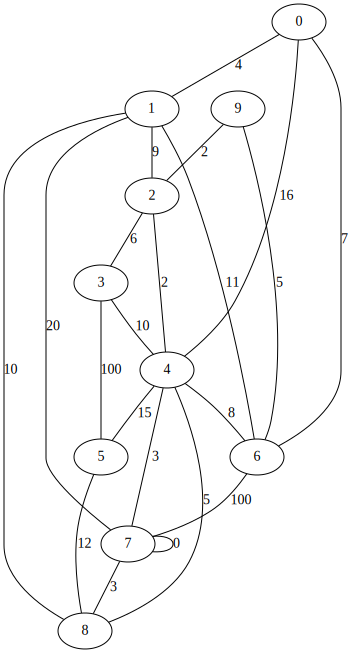

In [4]:
# visual representation
v = g.draw()
v

# Borůvka's algorithm
Using separate data structure for simplicity, will translate back to a Graph structure to display the resulting MST


In [5]:
class Boruvka(object):
    def __init__(self, graph):
        self.nodes = graph.get_nodes()
        self.edges = graph.get_edges()
        self.MST = Graph([])
        self.total_weight = 0
        # keep track of which subtree does each graph belong to
        self.subgraphs = {}
        
    def find_root(self, n):
        if n == self.subgraphs[n]:
            return n
        else:
            return self.find_root(self.subgraphs[n])
            
    
    # merges two disconnected sets into one
    def merge(self, subgraph_sizes, n1, n2):
        r1 = self.find_root(n1)
        r2 = self.find_root(n2)
        
        if (subgraph_sizes[r1] < subgraph_sizes[r2]):
            self.subgraphs[r1] = r2

        elif (subgraph_sizes[r1] > subgraph_sizes[r2]):
            self.subgraphs[r2] = r1
            
        else:
            self.subgraphs[r2] = r1
            subgraph_sizes[r1] += 1

            
    
    def get_boruvka(self):
        print('*' * 45)            
        # initially, number of subgraphs is equal to the number of all nodes
        num_subgraphs = len(self.nodes)
        # size of all subgraphs is equal to 1
        size_subgraphs = {}
        # cheapest edge for each component - initially -1 for every node
        cheapest = {}
        
        # initiate the variables
        for node in self.nodes:
            self.subgraphs[node] = node
            cheapest[node] = -1
            size_subgraphs[node] = 1
        
        # while more than 1 subgraph
        while num_subgraphs > 1:
            
            # traversing through each edge, find the shortest connection between subtrees
            for uv in self.edges:
                # for each edge uv
                # u - node 1, v - node 2
                # w - weight of the edge
                u = uv[0]
                v = uv[1]
                w = uv[2]
                
                # find the root of both subgraphs
                u_subgraph = self.find_root(u)
                v_subgraph = self.find_root(v)
                
                # are u and v in different subgraphs?
                if(u_subgraph != v_subgraph):
                    
                    # ux - the cheapest edge for the component of u
                    ux = cheapest[u_subgraph]
                    # vx - the cheapest edge for the component of v
                    vx = cheapest[v_subgraph]
                    
                    # check if processed edge is is the cheapest for u subgraph to connect to another subgraph
                    # pick edge uv if ux is undefined, ux weight is more or equal to uv
                    if(ux == -1 or ux[2] > w or ux[2] == w):
                        cheapest[u_subgraph] = uv
                    else:
                        self.edges

                    # check if processed edge is is the cheapest for v subgraph to connect to another subgraph
                    # pick edge uv if vx is undefined, vx weight is more or equal to uv
                    if(vx == -1 or vx[2] > w or vx[2] == w):
                        cheapest[v_subgraph] = uv
                    
            # for each node which has the cheapest edge set, add the edge to the MST graph
            for node in self.nodes:
                if(cheapest[node] != -1):
                    u = cheapest[node][0]
                    v = cheapest[node][1]
                    w = cheapest[node][2]
                    
                    # find v subgraph root
                    vs = self.find_root(v)
                    # find u subgraph root
                    us = self.find_root(u)
                    
                    # if u and v are in different subgraphs, add the connection
                    if(us != vs):
                        self.total_weight += w
                        self.merge(size_subgraphs, u, v)
                        # add it to the visual representation of the MST Graph as well
                        self.MST.add_edge(u, v, w)
                        print("Added ", u, " to ", v, " connection.")
                        # connected two subgraphs - one less subgraph
                        num_subgraphs -= 1
                    
            
            print("End of iteration. Number of subgraphs: ", num_subgraphs, '\n', '*' * 45, "\n\n")
            
            # reset cheapest, find it again for newly formed subtrees
            for node in self.nodes:
                cheapest[node] = -1
                
                
        print('*' * 45)            
        print("Finished with a single graph. Total weight: ", self.total_weight)
        print('*' * 45)            
        
        return self.MST

    
    
boruvka = Boruvka(g)
MST = boruvka.get_boruvka()
    

*********************************************
Added  0  to  1  connection.
Added  9  to  6  connection.
Added  7  to  8  connection.
Added  9  to  2  connection.
Added  2  to  3  connection.
Added  2  to  4  connection.
Added  5  to  8  connection.
End of iteration. Number of subgraphs:  3 
 ********************************************* 


Added  0  to  6  connection.
Added  4  to  7  connection.
End of iteration. Number of subgraphs:  1 
 ********************************************* 


*********************************************
Finished with a single graph. Total weight:  44
*********************************************


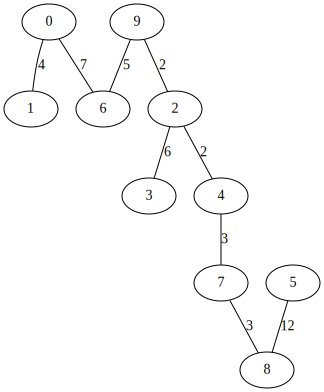

In [6]:
m = MST.draw()
m